In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!pip install timm

     |████████████████████████████████| 376 kB 4.2 MB/s 


In [ ]:
import typing
import io
import os
import pickle
import json

import timm
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
#from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

import os 
import pandas as pd
from PIL import Image
import numpy as np
import cv2
# path="/content/drive/MyDrive/DFUC2021_train/images"
# pathcsv="/content/drive/MyDrive/DFUC2021_train/Training_list1.csv"
# readptah=pd.read_csv(pathcsv)
# sample=readptah.values.tolist()[0]
# img,label=sample
# img=np.array(Image.open(os.path.join(path,img)))

# import matplotlib.pyplot as plt
# img.shape
#imge1=img[:,:,1]
#plt.imshow(imge1)

#!pip install albumentations

#! pip install albumentations==0.4.6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#dataset
import torch
import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
# Prepare Model
#vit_model = timm.create_model('vit_large_patch16_384', pretrained=True).to("cuda")

import timm
print("Available Vision Transformer Models: ")
print(timm.list_models("vit*"))
#################################################### transformer model #############################
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=pretrained)
        #if pretrained:
        #   self.model = timm.create_model(CFG['model_arch'], pretrained=True)
            #self.model.load_state_dict(torch.load(MODEL_PATH))
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)
        #self.model.classifier = nn.Linear(self.model.classifier.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x
    
model = ViTBase16(n_classes=4, pretrained=True).to(device)
model.to(device)
PATH='/content/drive/MyDrive/Tranformers_Dfuc2021/model_vit.pth'
model.load_state_dict(torch.load(PATH))
#model.load_state_dict(torch.load(PATH, map_location=device))
vit_model=model
vit_model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Available Vision Transformer Models: 
['vit_base_patch16_224', 'vit_base_patch16_224_in21k', 'vit_base_patch16_224_miil', 'vit_base_patch16_224_miil_in21k', 'vit_base_patch16_384', 'vit_base_patch32_224', 'vit_base_patch32_224_in21k', 'vit_base_patch32_384', 'vit_base_r26_s32_224', 'vit_base_r50_s16_224', 'vit_base_r50_s16_224_in21k', 'vit_base_r50_s16_384', 'vit_base_resnet26d_224', 'vit_base_resnet50_224_in21k', 'vit_base_resnet50_384', 'vit_base_resnet50d_224', 'vit_huge_patch14_224_in21k', 'vit_large_patch16_224', 'vit_large_patch16_224_in21k', 'vit_large_patch16_384', 'vit_large_patch32_224', 'vit_large_patch32_224_in21k', 'vit_large_patch32_384', 'vit_large_r50_s32_224', 'vit_large_r50_s32_224_in21k', 'vit_large_r50_s32_384', 'vit_small_patch16_224', 'vit_small_patch16_224_in21k', 'vit_small_patch16_384', 'vit_small_patch32_224', 'vit_small_patch32_224_in21k', 'vit_small_patch32_384', 'vit_small_r26_s32_224', 'vit_small_r26_s32_224_in21k', 'vit_small_r26_s32_384', 'vit_small_resn

In [ ]:
print(vit_model)

ViTBase16(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (n

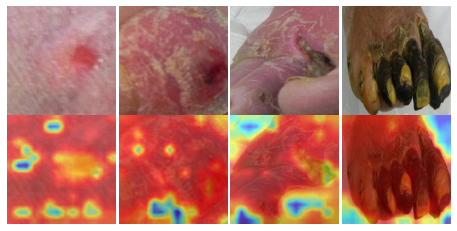

In [ ]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)
    
# https://github.com/jacobgil/vit-explain/blob/main/vit_explain.py
def show_mask_on_image(img, mask):
    mask = cv2.resize(mask, (img.shape[0], img.shape[1]))
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def visualize(images, results, name="attn_map_nae_high.png"):
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(8, 4))
    for i in range(2):
        for j in range(4):
            # if i == 1:
            #     ax[i, j].set_title(f"Prediction: {preds[i]} \n"
            #                         'Confidence: {:.2f}'.format(probs[i]), 
            #                        fontsize=12)
            ax[i, j].axis("off")
            
            if i == 0:
                _ = ax[i, j].imshow(images[j])
            elif i == 1:
                _ = ax[i, j].imshow(results[j])
    
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    fig.savefig(f"{name}", dpi=300, bbox_inches="tight")
    
roller = VITAttentionRollout(vit_model, discard_ratio=0.9)
images, results = [], []

paths='/content/drive/MyDrive/Tranformers_Dfuc2021/set2'
oslstd=os.listdir(paths)
high_conf_paths=[]
for i in oslstd:
    pathf=os.path.join(paths,i)
    high_conf_paths.append(pathf)

for i, image_path in enumerate(high_conf_paths):
    im = Image.open(image_path)
    x = transform(im).to(DEVICE)
    mask = roller(x.unsqueeze(0))
    output = show_mask_on_image(np.array(im.resize((224, 224))), mask)

    images.append(np.array(im.resize((224, 224))))
    results.append(output)
    #preds.append(high_preds[i])
    #probs.append(high_confs[i])
visualize(images, results, name="attn_map2.png")

In [ ]:
!unzip /content/drive/MyDrive/Tranformers_Dfuc2021/testdfucdataset.zip

Archive:  /content/drive/MyDrive/Tranformers_Dfuc2021/testdfucdataset.zip
   creating: testdfucdataset/
  inflating: testdfucdataset/501000.jpg  
  inflating: testdfucdataset/501001.jpg  
  inflating: testdfucdataset/501002.jpg  
  inflating: testdfucdataset/501003.jpg  
  inflating: testdfucdataset/501004.jpg  
  inflating: testdfucdataset/501005.jpg  
  inflating: testdfucdataset/501006.jpg  
  inflating: testdfucdataset/501007.jpg  
  inflating: testdfucdataset/501008.jpg  
  inflating: testdfucdataset/501009.jpg  
  inflating: testdfucdataset/501010.jpg  
  inflating: testdfucdataset/501011.jpg  
  inflating: testdfucdataset/501012.jpg  
  inflating: testdfucdataset/501013.jpg  
  inflating: testdfucdataset/501014.jpg  
  inflating: testdfucdataset/501015.jpg  
  inflating: testdfucdataset/501016.jpg  
  inflating: testdfucdataset/501017.jpg  
  inflating: testdfucdataset/501018.jpg  
  inflating: testdfucdataset/501019.jpg  
  inflating: testdfucdataset/501020.jpg  
  inflating: t

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import cv2
from collections import defaultdict
import copy
import random
import shutil
import albumentations as A
#from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True
from torchvision import transforms
#import ttach as tta
import natsort

#transforms11 = tta.Compose(
    #[
        #tta.HorizontalFlip(),
        #tta.Rotate90(angles=[0, 180]),
        #tta.Scale(scales=[1, 2, 4]),
        #tta.Multiply(factors=[0.9, 1, 1.1]),        
    #]
#)
valid_transform=transforms.Compose([#transforms.Resize(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485,0.456,0.406],[0.299,0.224,0.225])
                                   ])
#tta_model = tta.SegmentationTTAWrapper(model, transforms)
####################### path of test dataset ######################
path_test="/content/drive/MyDrive/testdfucdataset"
lstdir=os.listdir(path_test)
data = {
    'case': [],
    'class': [],
} 
featclass3=[]
labels=[]
for i in natsort.natsorted(lstdir):
  #print(i)
  pathtest=os.path.join(path_test,i)
  #print(pathtest)
  img=cv2.imread(pathtest)
  img_bgr_rgb= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resized = cv2.resize(img_bgr_rgb,(224,224), interpolation = cv2.INTER_CUBIC)
  #image=Image.open(pathval)
  image = Image.fromarray(resized)
  #image=Image.open(pathval)
  #image_g=np.array(Image.open(pathval))
  img_t=valid_transform(image)
  #print(img_t.shape)
  img_t1=torch.unsqueeze(img_t,dim=0)
  #print(img_t1.shape)
  img_t1=img_t1.float().to(device)
  outputs = vit_model(img_t1)
  #outputs=torch.nn.Softmax(outputs,1)
  _, predicted = torch.max(outputs.data, 1) # take maximum index from logitis or predcition
    
  feat=np.array(outputs.data.detach().cpu())
  feat1=np.squeeze(feat)
  #print(feat1)
  featclass3.append(feat1)
  #print(predicted.detach().cpu().numpy())
  p=np.array(predicted.detach().cpu())
  print(np.squeeze(p))
  labels.append(np.squeeze(p))
  #predicted1.append(predicted.detach().cpu().numpy())
  data["case"].append(i)
  data["class"].append(np.squeeze(p)) ## save prediction

3
3
1
1
3
0
0
1
3
3
0
0
1
3
1
3
1
1
0
0
0
3
1
1
1
1
1
1
0
1
0
3
0
0
1
1
1
1
1
1
1
1
1
0
1
3
3
1
1
1
3
0
1
1
1
1
3
1
0
0
3
1
1
1
1
0
1
1


RuntimeError: ignored